# OIH Queries 

What follows are some example SPARQL queries used in OIH for the test interface


## Setup and inits

### Installs

In [1]:
# %%capture
#@title
!pip install -q SPARQLWrapper
!pip install -q cython
# !pip install -q cartopy
!pip install -q geopandas
!pip install -q contextily==1.0rc2
!pip install -q pyshacl
!pip install -q 'PyLD>=2.0.3'
!pip install -q flatten_json
!pip install -q 'fsspec>=0.3.3'
!pip install -q s3fs
!pip -q install SPARQLWrapper
# !pip install -q boto3
# !pip install -q kglab

### Imports

In [6]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import dask, boto3
import dask.dataframe as dd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely
# import kglab as kg

oih = "https://graph.collaborium.io/blazegraph/namespace/oih/sparql"
oihdev = "https://graph.collaborium.io/blazegraph/namespace/oihdev/sparql"
oihad = "https://graph.collaborium.io/blazegraph/namespace/aquadocs/sparql"

### Support Functions

In [7]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

## Queries

What follows is a set of queries designed to provide a feel for the OIH graph

### Simple Count

How many triples are there?

In [8]:
rq_count = """SELECT (COUNT(*) as ?Triples) 
WHERE 
  {
      { ?s ?p ?o } 
  }
"""

In [9]:
dfsc = get_sparql_dataframe(oih, rq_count)
dfsc.head()

,Triples
0,159766


### Predicate Counts

This gives an overview of unique predicates that connect a subject to an object.  This gives us both an idea of the properties we are using on things and count of their usage.


In [10]:
rq_pcount = """SELECT ?p (COUNT(?p) as ?pCount)
WHERE
{
  ?s ?p ?o .
}
GROUP BY ?p
"""

In [15]:
dfc = get_sparql_dataframe(oih, rq_pcount)
dfc['pCount'] = dfc["pCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)

In [16]:
dfc_sorted = dfc.sort_values('pCount', ascending=False)
dfc_sorted.head(10)

,p,pCount
33,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,32625
5,https://schema.org/keywords,17359
4,https://schema.org/url,14236
2,https://schema.org/name,12594
17,https://schema.org/provider,5136
0,https://schema.org/description,4895
6,https://schema.org/sameAs,4889
27,https://schema.org/legalName,4823
3,https://schema.org/propertyID,4265
7,https://schema.org/value,4265


In [17]:
rcount = len(dfc_sorted)
print(rcount)

34


In [18]:
ts = dfc_sorted.tail(38)['pCount'].sum()
print(ts)

159766


In [19]:
hs = dfc_sorted.head(10)
hs.append({'p':'Other','pCount':ts}, ignore_index=True) 
# hs.set_index('p', inplace=True)
hs.head(15)

,p,pCount
33,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,32625
5,https://schema.org/keywords,17359
4,https://schema.org/url,14236
2,https://schema.org/name,12594
17,https://schema.org/provider,5136
0,https://schema.org/description,4895
6,https://schema.org/sameAs,4889
27,https://schema.org/legalName,4823
3,https://schema.org/propertyID,4265
7,https://schema.org/value,4265


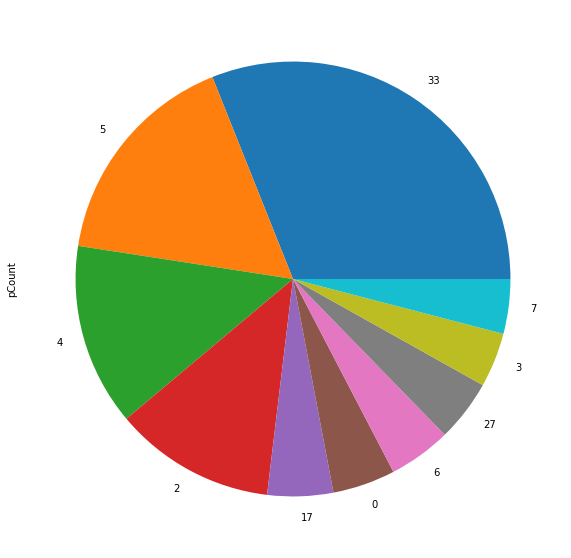

In [20]:
plot = hs.plot.pie(y='pCount',x='p',legend=False, figsize=(10, 10))

### OIH Base Query

In [21]:
rq_main = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s   ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }

        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [22]:
df = get_sparql_dataframe(oih, rq_main)
df.head(5)

,g,s,type,score,name,url,lit,description,headline
0,urn:gleaner:milled:obis:13392d707024cdd4e509d6...,t670214,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/b91d89db-79d6-4bd3-84...,coral,The purpose of the Coral Reef Evaluation and M...,None
1,urn:gleaner:milled:obis:18d1180a74c200d06f9114...,t671476,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/46005357-02b8-4f17-b0...,coral,The purpose of the Coral Reef Evaluation and M...,None
2,urn:gleaner:milled:obis:24bac898cda34444176ec4...,t673848,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/d4ec17b8-fc96-49b9-b7...,coral,The purpose of the Coral Reef Evaluation and M...,None
3,urn:gleaner:milled:obis:24d453e3a4ea6d1f117e5c...,t673875,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/36bca81c-6d77-4fd4-a9...,coral,The purpose of the Coral Reef Evaluation and M...,None
4,urn:gleaner:milled:obis:2bf98aa888d856b8706176...,t675633,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/431f96f7-521c-4182-ae...,coral,The purpose of the Coral Reef Evaluation and M...,None


### OIH Gleaner Query

In [23]:
rq_maingl = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s  ?wat ?orgname ?domain ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [27]:
df = get_sparql_dataframe(oihad, rq_maingl)
df.head(5)

,g,s,wat,orgname,domain,type,score,name,url,lit,description,headline
0,urn:gleaner:milled:obis:c18f3c68e05fc5820e5daf...,t3333357,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Nematoda from Kenya and Zanzibar,https://obis.org/dataset/aa9787d6-c4db-4fde-8e...,Coral,Data on the species and trophic composition of...,None
1,urn:gleaner:milled:obis:4411c25cf985f8253c0a13...,t3323787,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Kenyan reef corals sampled in November 1990,https://obis.org/dataset/447b61a2-4a04-4394-af...,Coral,This dataset contains a taxonomic list of cora...,None
2,urn:gleaner:summoned:aquadocs:bac548e654f7097a...,oai:aquadocs.org:1834/1987,https://www.re3data.org/repository/aquadocs,AquaDocs,https://aquadocs.org,https://schema.org/CreativeWork,1.0,Is competition for space between the encrustin...,https://www.oceandocs.org/handle/1834/1987,Coral,- Temperaturas del agua de mar por encima del...,None
3,urn:gleaner:summoned:aquadocs:bac548e654f7097a...,oai:aquadocs.org:1834/10551,https://www.re3data.org/repository/aquadocs,AquaDocs,https://aquadocs.org,https://schema.org/CreativeWork,1.0,Study of biotic communities for artificial ree...,https://www.oceandocs.org/handle/1834/10551,Coral,- Persian Gulf waters (Hormuzgan Province) we...,None
4,urn:gleaner:summoned:aquadocs:bac548e654f7097a...,oai:aquadocs.org:1834/12281,https://www.re3data.org/repository/aquadocs,AquaDocs,https://aquadocs.org,https://schema.org/CreativeWork,1.0,Molecular diversity of Symbiodinium spp. withi...,https://www.oceandocs.org/handle/1834/12281,Coral,- Reef-building coral harbor communities of p...,None


## Query for prov

Count (count(distinct ?tag) as ?count) 

Need to look for the date in the prov record too.  I keep it by day granularity, so I should be able to see the difference if I focos on a specific repo or look over the dates

In [114]:
rq_prov = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?wat ?orgname ?domain
        """

In [134]:
rq_prov2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT ( COUNT(?s) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           graph ?g {
             VALUES (?type) { ( schema:CreativeWork ) ( schema:Map )  ( schema:Person )  ( schema:Organization )  ( schema:Dataset )  ( schema:Course ) } 
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
                GROUP BY ?wat ?orgname ?domain

        """

In [135]:
dfp = get_sparql_dataframe(oihad, rq_prov2)
dfp['count'] = dfp["count"].astype(int) # convert count c to int
dfp.set_index('orgname', inplace=True)
dfp.head(10)

,count,wat,domain
orgname,,,
Marine Training EU,944,https://www.re3data.org/repository/marinetraining,https://marinetraining.eu/
Ocean Biodiversity Information System,9036,https://www.re3data.org/repository/obis,https://obis.org
OceanExpert UNESCO/IOC Project Office for IODE,502,https://www.re3data.org/repository/oceanexpert,https://oceanexpert.org/
Ocean Best Practices,8223,https://www.re3data.org/repository/obps,https://oih.oceanbestpractices.org
AquaDocs,155498,https://www.re3data.org/repository/aquadocs,https://aquadocs.org


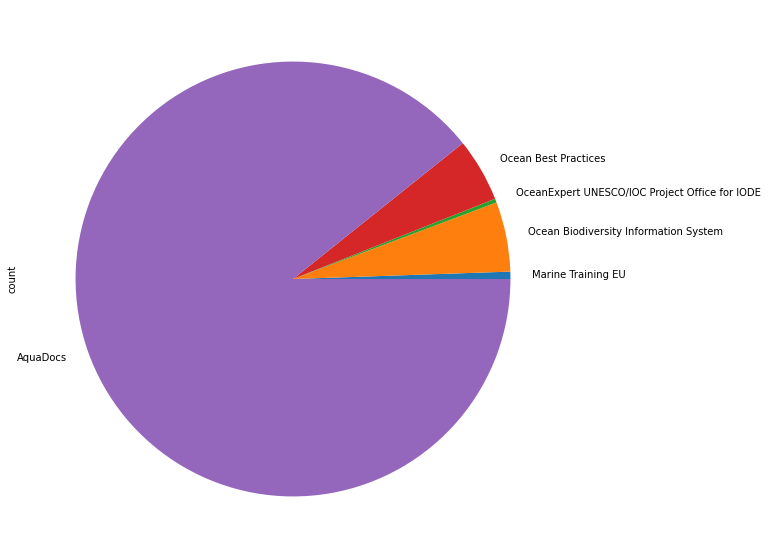

In [136]:
plot = dfp.plot.pie(y='count',legend=False, figsize=(10, 10))

In [132]:
rq_provdate = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?s) as ?count) ?time ?orgname  
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?time ?orgname  
        """

In [133]:
dfpd = get_sparql_dataframe(oihad, rq_provdate)
dfpd.head(10)

,count,time,orgname
0,314,2021-08-09T00:00:00.000Z,Marine Training EU
1,4214,2021-08-09T00:00:00.000Z,Ocean Biodiversity Information System
2,1,2021-08-09T00:00:00.000Z,Ocean Best Practices
3,502,2021-08-09T00:00:00.000Z,OceanExpert UNESCO/IOC Project Office for IODE
4,1,2021-08-09T00:00:00.000Z,AquaDocs


In [294]:
dfpd = get_sparql_dataframe(oihad, rq_provdate)
dfpd['count'] = dfpd["count"].astype(int) # convert count c to int
dfpd.set_index('time', inplace=True)
dfpd.head()


,count,orgname
time,,
2021-08-09T00:00:00.000Z,314,Marine Training EU
2021-08-09T00:00:00.000Z,4214,Ocean Biodiversity Information System
2021-07-31T00:00:00.000Z,1,AquaDocs
2021-07-30T00:00:00.000Z,2,Ocean Best Practices
2021-07-31T00:00:00.000Z,2,Ocean Best Practices


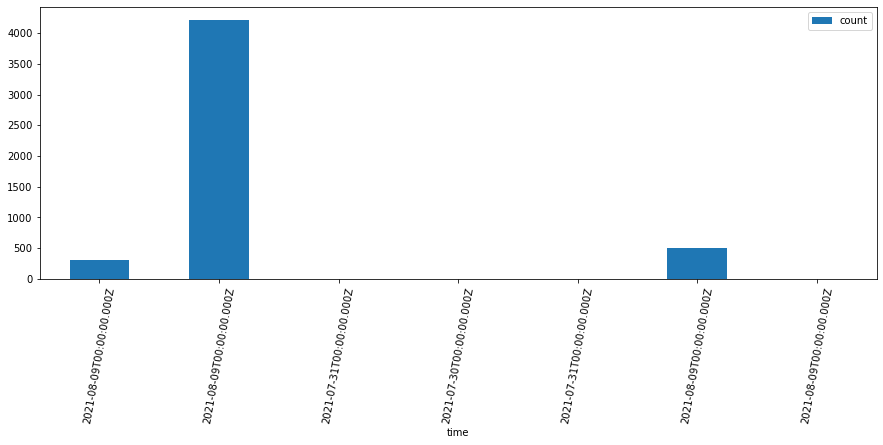

In [295]:
ax = dfpd.plot.bar(rot=80, stacked=True, figsize=(15, 5))

## Feed query

Goal here is see if the prov will give us the elements for an RSS feed.  
The [RSS specs](https://validator.w3.org/feed/docs/rss2.html) give us the elements we need to populate.  Focus on; title(name), date, author, description

* Element 	Description 	Example
* title 	The title of the item. 	Venice Film Festival Tries to Quit Sinking
* link 	The URL of the item. 	http://www.nytimes.com/2002/09/07/movies/07FEST.html
* description 	The item synopsis. 	Some of the most heated chatter at the Venice Film Festival this week was about the way that the arrival of the stars at the Palazzo del Cinema was being staged.
* author 	Email address of the author of the item. More. 	oprah@oxygen.net
* category 	Includes the item in one or more categories. More. 	Simpsons Characters
* comments 	URL of a page for comments relating to the item. More. 	http://www.myblog.org/cgi-local/mt/mt-comments.cgi?entry_id=290
* enclosure 	Describes a media object that is attached to the item. More. 	<enclosure url="http://live.curry.com/mp3/celebritySCms.mp3" length="1069871" type="audio/mpeg"/>
* guid 	A string that uniquely identifies the item. More. 	<guid isPermaLink="true">http://inessential.com/2002/09/01.php#a2</guid>
* pubDate 	Indicates when the item was published. More. 	Sun, 19 May 2002 15:21:36 GMT
* source 	The RSS channel that the item came from. More. 	<source url="http://www.quotationspage.com/data/qotd.rss">Quotes of the Day</source>

In [119]:
rq_provdatelist = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT  ?time ?orgname ?memval  ?memname ?memdesc
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:value ?memval .
           ?mem schema:name ?memname .
           ?mem schema:description ?memdesc .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?time)
        LIMIT 1000

        """

In [120]:
dfpl = get_sparql_dataframe(oih, rq_provdatelist)
dfpl.head(10)

,time,orgname,memval,memname,memdesc
0,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4059,Coastal Benthic Ecology,Contents\n\nThe course provides a thorough int...
1,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4191,Methods for Implementation of Surveillance Pro...,General course objectives\n\nThe course aims t...
2,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4347,Adaptation Planning,Course Description:\n\nThe course examines cha...
3,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4158,Business Development and Innovation (Aquatic R...,General course objectives\n\nThe objective of ...
4,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/3910,Machine Vision,Course content\n\nIntroduction to machine visi...
5,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4332,Arctic Ocean Governance,Course Description:\n\nThe course will discuss...
6,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4115,Mathematical Biology,General course objectives\n\nThe course is an ...
7,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4094,Methodology and Sampling in Environmental Mana...,"Practical sampling of soil, water and bioindic..."
8,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4343,Global Fisheries and Seafood,Course Description:\n\nThe course offers a det...
9,2021-05-12T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4139,Biological Oceanography,General course objectives\n\nBiological oceano...


## Types Breakdown


In [121]:
rq_types = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?type) as ?count) ?type   
        WHERE
        {
           ?s rdf:type ?type
        }
        GROUP BY ?type  
        ORDER BY DESC(?count)
        """

In [122]:
dft = get_sparql_dataframe(oihad, rq_types)
dft['count'] = dft["count"].astype(int) # convert count c to int
dft.set_index('type', inplace=True)
dft.head(10)

,count
type,
https://schema.org/Person,107563
https://schema.org/PropertyValue,44658
https://schema.org/CreativeWork,40389
https://schema.org/ListItem,40387
https://schema.org/Organization,21224
http://www.w3.org/ns/prov#Entity,10064
http://www.w3.org/ns/prov#Activity,5032
http://www.w3.org/ns/prov#Collection,5032
http://www.w3.org/ns/prov#Organization,5032


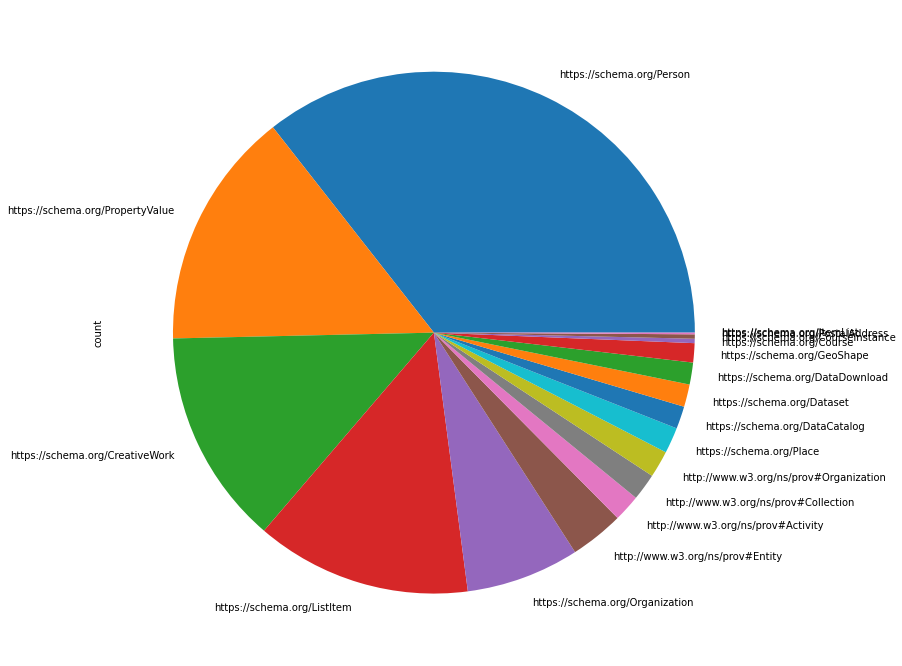

In [123]:
plot_t = dft.plot.pie(y='count',legend=False, figsize=(12, 12))